## Load packages

In [1]:
using Trapz, Revise, Cuba, Interpolations, StatsPlots, IntervalSets, BAT, FileIO, LaTeXStrings, HypergeometricFunctions, SpecialFunctions, BenchmarkTools, Distributions, KernelDensity, DelimitedFiles, Memoize, NestedSamplers, JLD2, Roots, AbstractMCMC, Random, StatsBase

model = "GWTC3_lognormal3"
include("events.jl")
include("utils.jl")

source_to_detector_factor (generic function with 1 method)

In [2]:
h, ΩM, mc, σc, f = 0.674, 0.315, 15, 0.5, 1e-3
cosmo = LCDM(h, ΩM);
fpbh = 1e-3
log_fpbh = -3

-3

In [3]:
cosmo.t_at_z(1e-4)/3600/24/365

1.3803932684153122e10

In [4]:
cosmo.dDL_over_dz(0.1)

cosmo.dVC_over_dz(10.0)

cosmo.t_at_z(1e-4)/3600/24/365

1.3803932684153122e10

In [18]:
zs = 10 .^ (-4:0.05:1)

t1s = @. (cosmo.t_at_z(zs))^(-34/37)
t2s = @. (cosmo.t_at_z(zs))^(-31/37);

In [12]:
using Plots

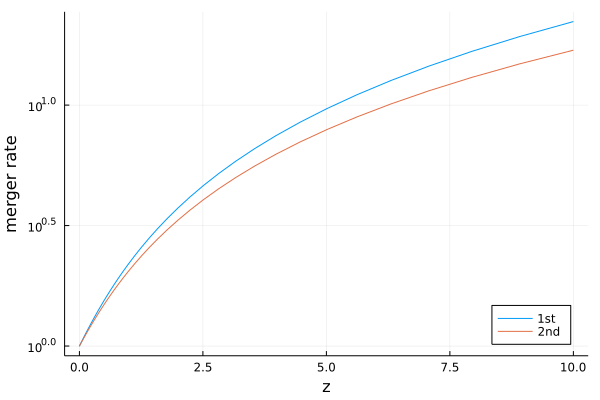

In [30]:
plot(zs, t1s ./ t1s[1], yaxis=:log, label="1st", legend=:bottomright, xlabel="z", ylabel="merger rate")
plot!(zs, t2s./ t2s[1],  label="2nd")

In [4]:
cosmo.z_at_DL(10)

1.367409469484551

In [5]:
injections0 = readdlm("/home/czc/projects/working/LIGO_posterior/O1_O2_O3_det_frame_SNR9.txt");
injections_ini = Injection(injections0[:, 1], injections0[:, 2], injections0[:, 3], injections0[:, 4], injections0[:, 5], injections0[:, 6], 266152887, 1.9945205796549974);
injections = update_cut(injections_ini, 11, 0);

Selecting injections with SNR 11 and IFAR 0 yr.


In [6]:
R_density = Lognormal_R_Density(mc, σc, f)
R_density.mergerRateDensity(cosmo, 10, 30, 1)
cal_Nexp(injections, cosmo, R_density)

11.287066215626934

In [7]:
posts0 = [get_post(event) for event in GWTC3_events_BBH];
posts = [reduce_post(post, 200) for post in posts0];

In [8]:
post = posts[1];
lnLike_single_event(cosmo, R_density, post)
lnLike_events(cosmo, R_density, posts)
merger_rate(cosmo, R_density, 1e-4), merger_rate_1st(cosmo, R_density, 1e-4) + merger_rate_2nd(cosmo, R_density, 1e-4)

(7.815343032282395, 7.859441441550927)

In [9]:
@btime R_density.mergerRateDensity(cosmo, 10, 30, 1)

  312.249 ns (14 allocations: 240 bytes)


0.018338227148530655

In [10]:
@btime R_density.mergerRateDensity1st(cosmo, 10, 30, 1)

  306.413 ns (14 allocations: 240 bytes)


0.018338227148530655

In [11]:
@btime R_density.mergerRateDensity2nd(cosmo, 10, 30, 1)

  1.787 μs (11 allocations: 704 bytes)


0.00019527729508153217

In [12]:
function lnLike(mc, σc, log_fpbh)
    fpbh = 10.0^log_fpbh
    R_density = Lognormal_R_Density(mc, σc, fpbh)
    lnL0(injections, cosmo, R_density, posts)
end


lnLike (generic function with 1 method)

In [13]:
lnLike(mc, σc, log_fpbh)

-897.9043404659548

In [14]:
@btime lnLike(mc, σc, log_fpbh)

  83.345 ms (4399369 allocations: 87.25 MiB)


-897.9043404659548

## Likelihood

In [15]:
@time lnLike(mc, σc, log_fpbh)

  0.102245 seconds (4.40 M allocations: 87.249 MiB, 11.93% gc time)


-897.9043404659548

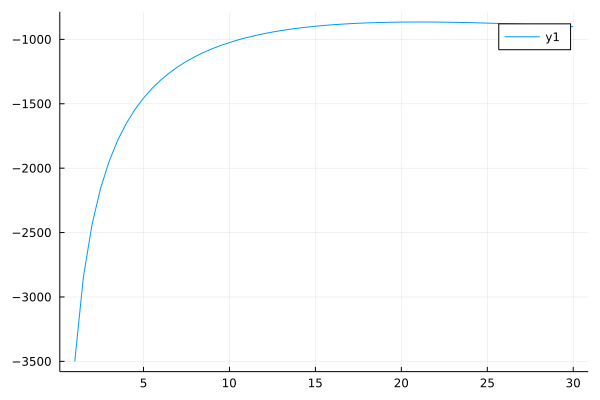

In [16]:
mcs = 1:0.5:30
lls = [lnLike(mc, σc, log_fpbh) for mc in mcs]
plot(mcs, lls)

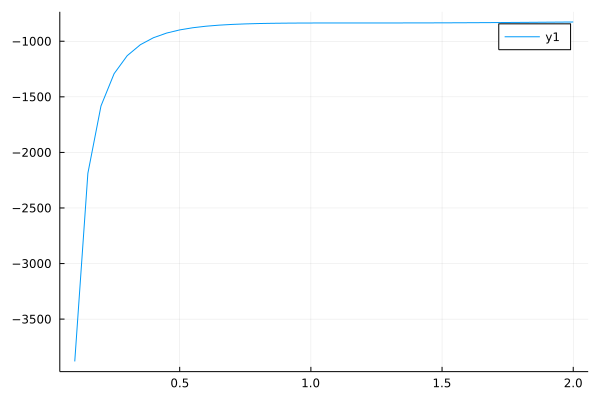

In [17]:
σcs = 0.1:0.05:2
lls = [lnLike(mc, σc, log_fpbh) for σc in σcs]
plot(σcs, lls)

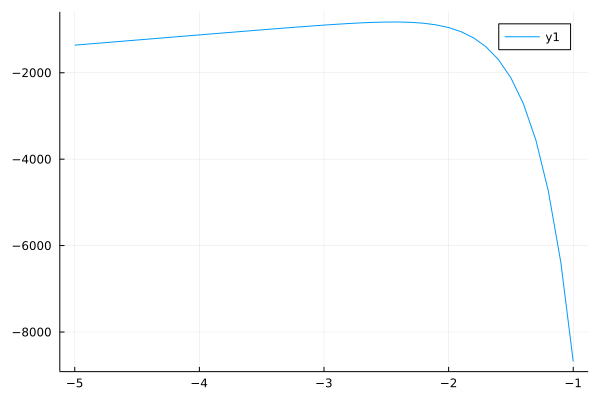

In [18]:
log_fpbhs = -5:0.1:-1
lls = [lnLike(mc, σc, log_fpbh) for log_fpbh in log_fpbhs]
plot(log_fpbhs, lls)

In [29]:
function age(h, ΩM, z)
    H0 = 100h / Mpc_to_km # 1/second
    prefactor = 2/3/H0/sqrt(1-ΩM)
    prefactor*asinh(sqrt((1/ΩM -1)/(1+z)^3))
end

age (generic function with 1 method)

In [56]:
@btime age(h, ΩM, 1)

  37.733 ns (1 allocation: 16 bytes)


1.8447379904870902e17

In [55]:
@btime cosmo.t_at_z(1)

  87.571 ns (2 allocations: 96 bytes)


1.8447028433040496e17

In [38]:
using HypergeometricFunctions

In [43]:
hyperT(x) = 2.0 * sqrt(x) * _₂F₁(1/6, 0.5, 7/6, -x^3)

hyperT (generic function with 1 method)

In [45]:
function DC_at_z(h, ΩM, z)
    H0 = 100h / Mpc_to_km # 1/second
    s = ((1 - ΩM) / ΩM)^(1 / 3)
    prefactor = lc / H0 / sqrt(s * ΩM)
    prefactor * (hyperT(s) - hyperT(s / (1 + z))) / Gpc_in_m # in Gpc
end

Ez(ΩM, z) = sqrt(1 - ΩM + ΩM * (1 + z)^3)

function dDC_over_dz(h, ΩM, z)
    H0 = 100h / Mpc_to_km # 1/second

    lc / H0 / Ez(ΩM, z) / Gpc_in_m # Gpc
end

dDL_over_dz(h, ΩM, z) = DC_at_z(h, ΩM, z) + (1 + z) * dDC_over_dz(h, ΩM, z) # Gpc

dDL_over_dz (generic function with 1 method)

In [52]:
@btime dDL_over_dz(h, ΩM, 0.9)

  448.919 ns (1 allocation: 16 bytes)


8.155187579972274

In [53]:
@btime cosmo.dDL_over_dz(1)

  91.628 ns (2 allocations: 96 bytes)


8.370352029290359

## Sampling

In [19]:
likelihood = ps -> LogDVal(lnLike(ps.mc, ps.σc, ps.log_fpbh))

prior = BAT.NamedTupleDist(
    mc=(5) .. (40),
    σc=(0.1) .. (2.0),
    log_fpbh=(-4) .. (-0.0)
)

posterior = PosteriorDensity(likelihood, prior);

In [21]:
true_par_values = (mc=mc, σc=σc, log_fpbh=-3)
@time likelihood(true_par_values)

  0.106827 seconds (4.40 M allocations: 87.249 MiB, 18.98% gc time)


LogDVal{Float64}(-897.9043404659548)

In [22]:
@time begin
    println("Start sampling.")

    burnin = MCMCMultiCycleBurnin(max_ncycles=1000)
    samples, chains = bat_sample(posterior, MCMCSampling(mcalg=MetropolisHastings(), nsteps=10^4, nchains=4, burnin=burnin))
end

save("backup/samples_$model.jld2", Dict("samples" => samples, "chains" => chains))
println(" ")
println("Finish sampling and save samples.")

Start sampling.


┌ Info: Initializing new RNG of type Random123.Philox4x{UInt64, 10}
└ @ BAT /home/czc/.julia/packages/BAT/XvOy6/src/algotypes/bat_default.jl:44
┌ Info: Using transform algorithm PriorSubstitution()
└ @ BAT /home/czc/.julia/packages/BAT/XvOy6/src/algotypes/bat_default.jl:44
┌ Info: Trying to generate 4 viable MCMC chain(s).
└ @ BAT /home/czc/.julia/packages/BAT/XvOy6/src/samplers/mcmc/chain_pool_init.jl:56
┌ Info: Selected 4 MCMC chain(s).
└ @ BAT /home/czc/.julia/packages/BAT/XvOy6/src/samplers/mcmc/chain_pool_init.jl:173
┌ Info: Begin tuning of 4 MCMC chain(s).
└ @ BAT /home/czc/.julia/packages/BAT/XvOy6/src/samplers/mcmc/multi_cycle_burnin.jl:35
┌ Info: MCMC Tuning cycle 1 finished, 4 chains, 0 tuned, 0 converged.
└ @ BAT /home/czc/.julia/packages/BAT/XvOy6/src/samplers/mcmc/multi_cycle_burnin.jl:65
┌ Info: MCMC Tuning cycle 2 finished, 4 chains, 0 tuned, 4 converged.
└ @ BAT /home/czc/.julia/packages/BAT/XvOy6/src/samplers/mcmc/multi_cycle_burnin.jl:65
┌ Info: MCMC Tuning cycle 3 fi

15945.125807 seconds (1.48 T allocations: 27.982 TiB, 39.28% gc time, 0.06% compilation time: 1% of which was recompilation)
 
Finish sampling and save samples.


In [23]:
samples = load("backup/samples_$model.jld2")["samples"];

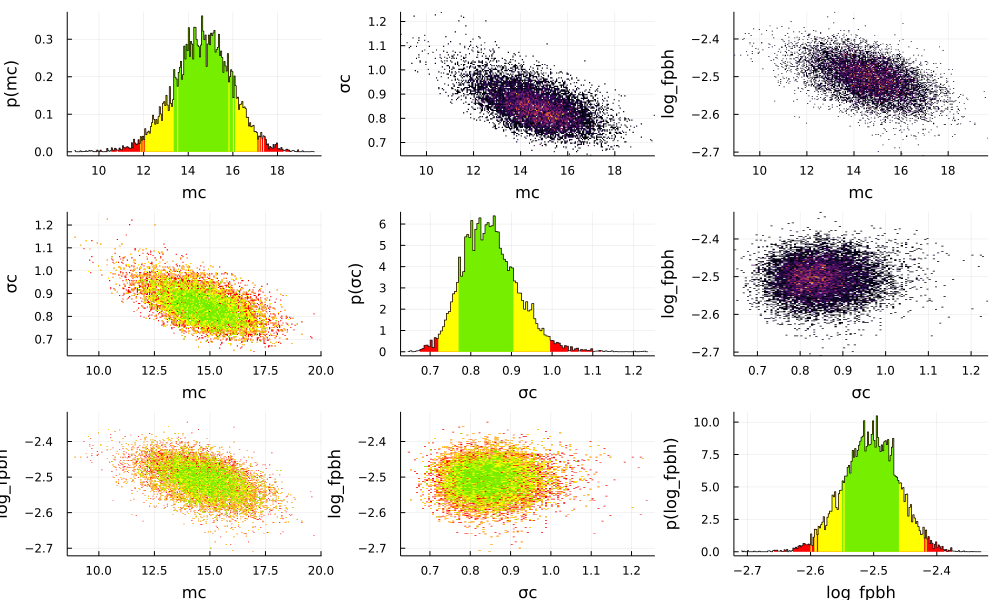

In [24]:
plot(samples)

In [25]:
# plot(
#     samples, :log_p3,
#     mean = true, std = true, globalmode = true, marginalmode = true,
#     nbins = 50, title = "Marginalized Distribution for y"
# )

In [26]:
sd = SampledDensity(posterior, samples)
display(sd)

BAT.jl - SampledDensity
──────────────────────────────

Sampling:
─────────────────────────
total number of samples:      11923
effective number of samples: (mc = 2115.430626384956, σc = 1852.711371277311, log_fpbh = 1342.5855700103882)


Parameter estimates:
─────────────────────────
number of free parameters: 3

NamedTuple{(:parameter, :mean, :std, :global_mode, :marginal_mode), Tuple{Symbol, Float64, Float64, Float64, Float64}}[(parameter = :mc, mean = 14.64358686920503, std = 1.3208662647895733, global_mode = 14.822273251206914, marginal_mode = 14.625), (parameter = :σc, mean = 0.8479237820984189, std = 0.0686102155870963, global_mode = 0.8287613576993014, marginal_mode = 0.8574999999999999), (parameter = :log_fpbh, mean = -2.5050076643804644, std = 0.04408814444256472, global_mode = -2.5042825264710036, marginal_mode = -2.495)]


Covariance matrix:
─────────────────────────
3×3 Named Matrix{Float64}
  cov ╲  │          mc           σc     log_fpbh
─────────┼───────────────────────

In [27]:
get_post(para, samples) = [a[para] for a in samples.v]

get_post (generic function with 1 method)

In [29]:
mc_posts = get_post(:mc, samples)
σc_posts = get_post(:σc, samples)
log_fpbh_posts = get_post(:log_fpbh, samples)

fpbh_posts = 10 .^ log_fpbh_posts;

In [30]:
R_posts = zeros(length(mc_posts))
Threads.@threads for i in 1:length(R_posts)
    R_posts[i] = merger_rate(mc_posts[i], σc_posts[i], fpbh_posts[i])
end

save("backup/R_posts_$model.jld2", Dict("samples" => R_posts))
R_posts = load("backup/R_posts_$model.jld2")["samples"];

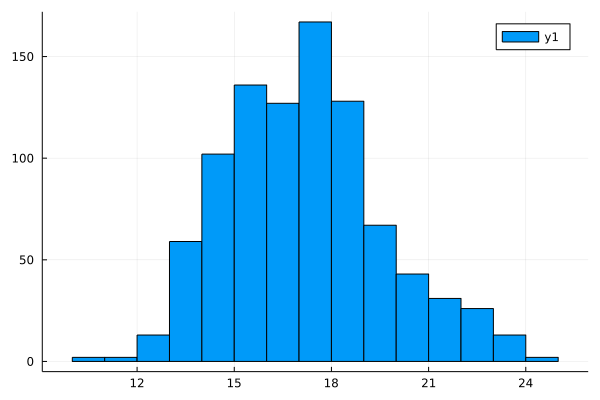

In [31]:
histogram(mc_posts)

In [33]:
get_quantile(posts) = quantile(posts, [0.05, 0.5, 0.95])

get_quantile (generic function with 1 method)

In [58]:
using Distributions
using Dynesty
# define a distribution
ndim = 5
d = MvNormal(ones(ndim))

loglikelihood(x) = logpdf(d, x)

prior_transform(p) = -10.0 .+ 20.0.*p

smplr = NestedSampler(ndim)

res = sample(loglikelihood, prior_transform, smplr; dlogz=0.5, )

# plot the results
Dynesty.cornerplot(res)

5468it [00:04, 1237.64it/s, +500 | bound: 11 | nc: 1 | ncall: 25533 | eff(%): 23.841 | loglstar:   -inf < -4.617 <    inf | logz: -14.864 +/-  0.143 | dlogz:  0.001 >  0.500]


(PyObject <Figure size 1180x1180 with 25 Axes>, PyCall.PyObject[PyObject <AxesSubplot:> PyObject <AxesSubplot:> … PyObject <AxesSubplot:> PyObject <AxesSubplot:>; PyObject <AxesSubplot:ylabel='$x_{2}$'> PyObject <AxesSubplot:> … PyObject <AxesSubplot:> PyObject <AxesSubplot:>; … ; PyObject <AxesSubplot:ylabel='$x_{4}$'> PyObject <AxesSubplot:> … PyObject <AxesSubplot:> PyObject <AxesSubplot:>; PyObject <AxesSubplot:xlabel='$x_{1}$', ylabel='$x_{5}$'> PyObject <AxesSubplot:xlabel='$x_{2}$'> … PyObject <AxesSubplot:xlabel='$x_{4}$'> PyObject <AxesSubplot:xlabel='$x_{5}$'>])

In [71]:
t1 = [t[1] for t in res["samples"]]

5968-element Vector{Float64}:
 -9.170953657529433
 -7.651368747140737
 -5.588936953692453
  8.188064220603323
 -9.53128849677256
 -6.5989847852066745
  8.818117384755908
  5.578427535729231
  9.552206085827912
  9.473847675927349
  8.591402009198887
 -6.465166176876956
  9.80286221757396
  ⋮
 -0.06514625455507428
 -0.47557066499629563
 -0.31037236628891485
 -0.03752906947991974
  0.05252291299056644
 -0.1570015927477968
 -0.4457751625654005
 -0.32515756419025976
  0.15512596206443874
  0.14693020166878057
  0.2137401245973649
  0.10245046772411115

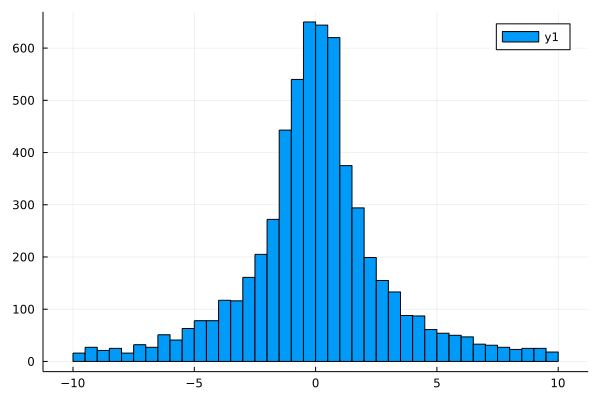

In [73]:
histogram(t1)